In [15]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.stats import norm, expon, lognorm, uniform
import matplotlib.pyplot as plt

# Copulas

### Mohsin Javed, June 13, 2019.

A copula is a distribution function $ C: \mathbb{R}^n \to [0, 1] $ such that 
all the marginals are standard uniform random variables.

By definition,

\begin{align*}
C(1, 1, \ldots, 1, u_j, 1, \ldots, 1) = u_j.
\end{align*}

Copulas allow us to use the dependence structure of one multivariate distribution for generating
samples of another multivariate distribution whose marginals can be specified arbitrarliy but 
whose dependence structure is inherited from the original multivariate distribution. 

Let's begin with a bivariate Gaussian distribution, with correlation $\rho$. A sample from 
such a distribution can be obtained by the following code. 

<IPython.core.display.Javascript object>


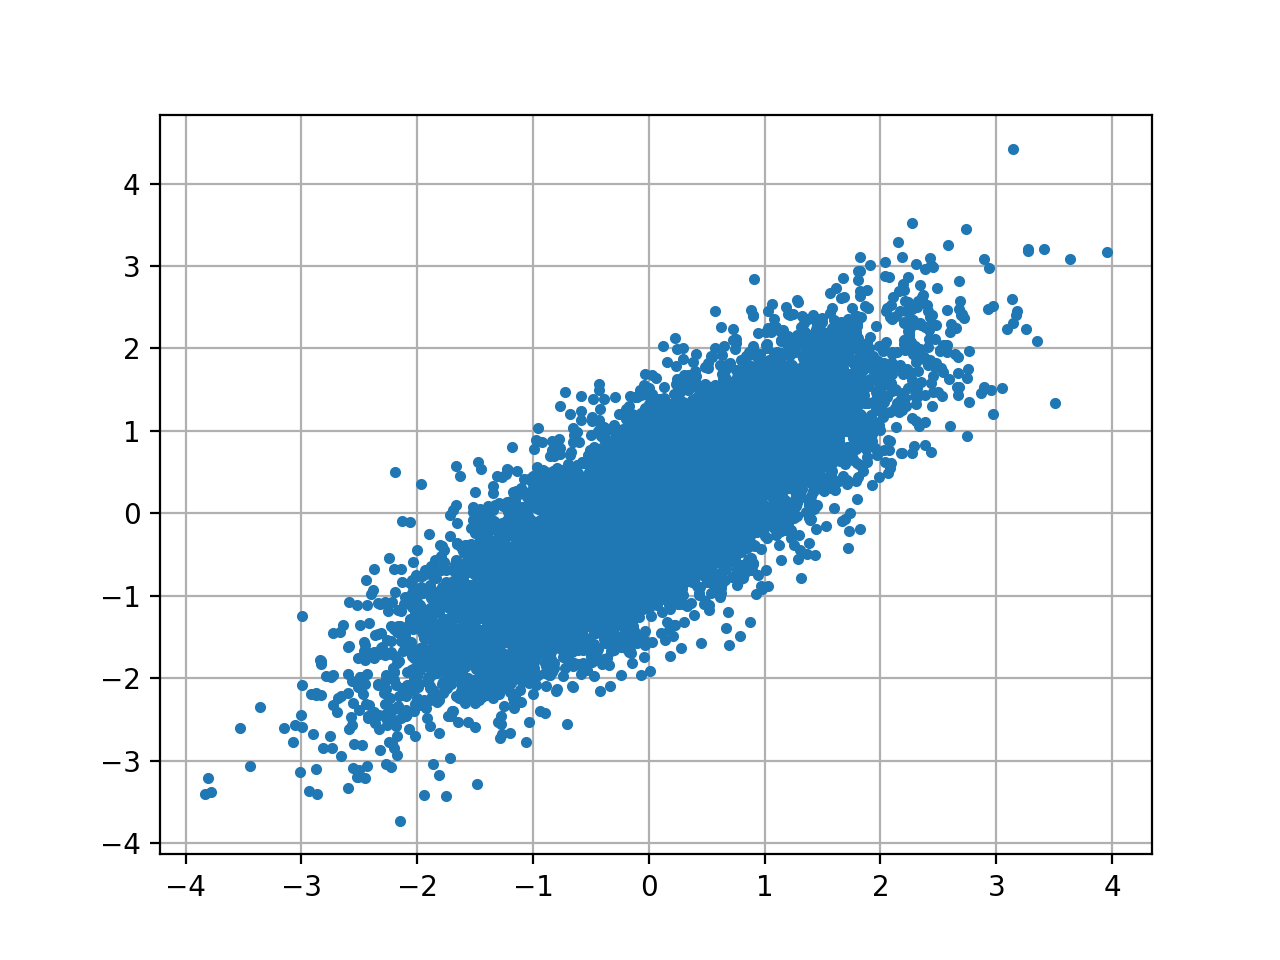

In [16]:
N = int(1e4)
rho = 0.8
s_1 = 1
s_2 = 1
Z = np.random.multivariate_normal([0, 0], [[s_1**2, rho], [rho, s_2**2]], N)
X = Z[:, 0]
Y = Z[:, 1]
plt.figure()
plt.plot(X, Y, '.')
plt.grid(True)

When we extract the marginals from the joint distribution, all informaton about the correlation i.e.,
how the two marginals dpended on each other is lost. 

<IPython.core.display.Javascript object>


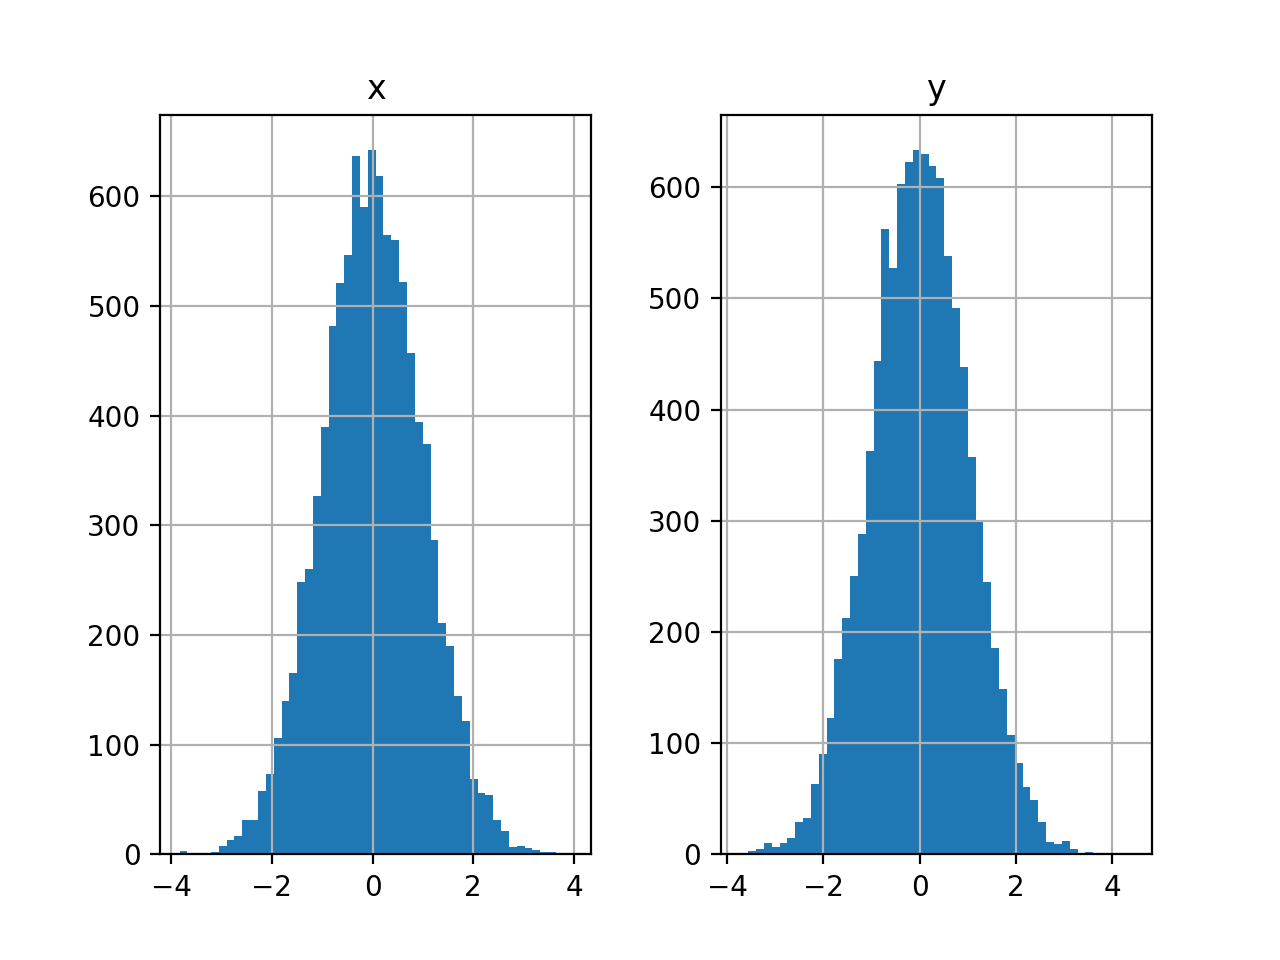

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f80def0>,
      dtype=object)

In [17]:
df_n = pd.DataFrame({'x': X, 'y': Y})
df_n.hist(bins=50, grid=True)

In [18]:
df_n['x'].corr(df_n['y'])

0.8021037675473812

Now we ask, how can we create two uniform random variables such that their dependence 
structure is the same as that of the dependence structure of the bivariate Gaussian distribution. Copulas answer this important question. First, let's review a standard theorem.

## Probability integral transform
For any random variable $X \sim F$, the random variable $U = F(X)$ is 
uniform in $[0, 1]$. 

### Proof

\begin{align*}
P(Y \leq y ) &= P(F(X) \leq y )\\
&= P(X \leq F^{-1}(y))\\
&= F(F^{-1}(y))\\
&= y.
\end{align*}

## Choosing a Copula
Given a set of marginal distributions $F_1, F_2, \ldots, F_n$, we can define the copula $C$ as,

\begin{align*}
C(U_1, U_2, \ldots, U_n ) = C(F_1(X_1), F_2(X_1), \ldots, F_n(X_1)).
\end{align*}

But how do we choose $C$? This is a fundamental question. By definition, $C$ has to be a multidimensional distribution function on the unit cube of an appropriate dimension. A popular choice of $C$ is the multivariate Gaussian distirbution function. This choice is called the _Gaussian Copula_.

Note that we can use the Gaussian copula on any set of marginal distributions. In the present example, the marginals $F_1$ and $F_2$ themselves happen to be Gaussian, but this is not necessary for applying a Gaussian Copula.

We can generate a sample with distribution $C$ as:

<IPython.core.display.Javascript object>


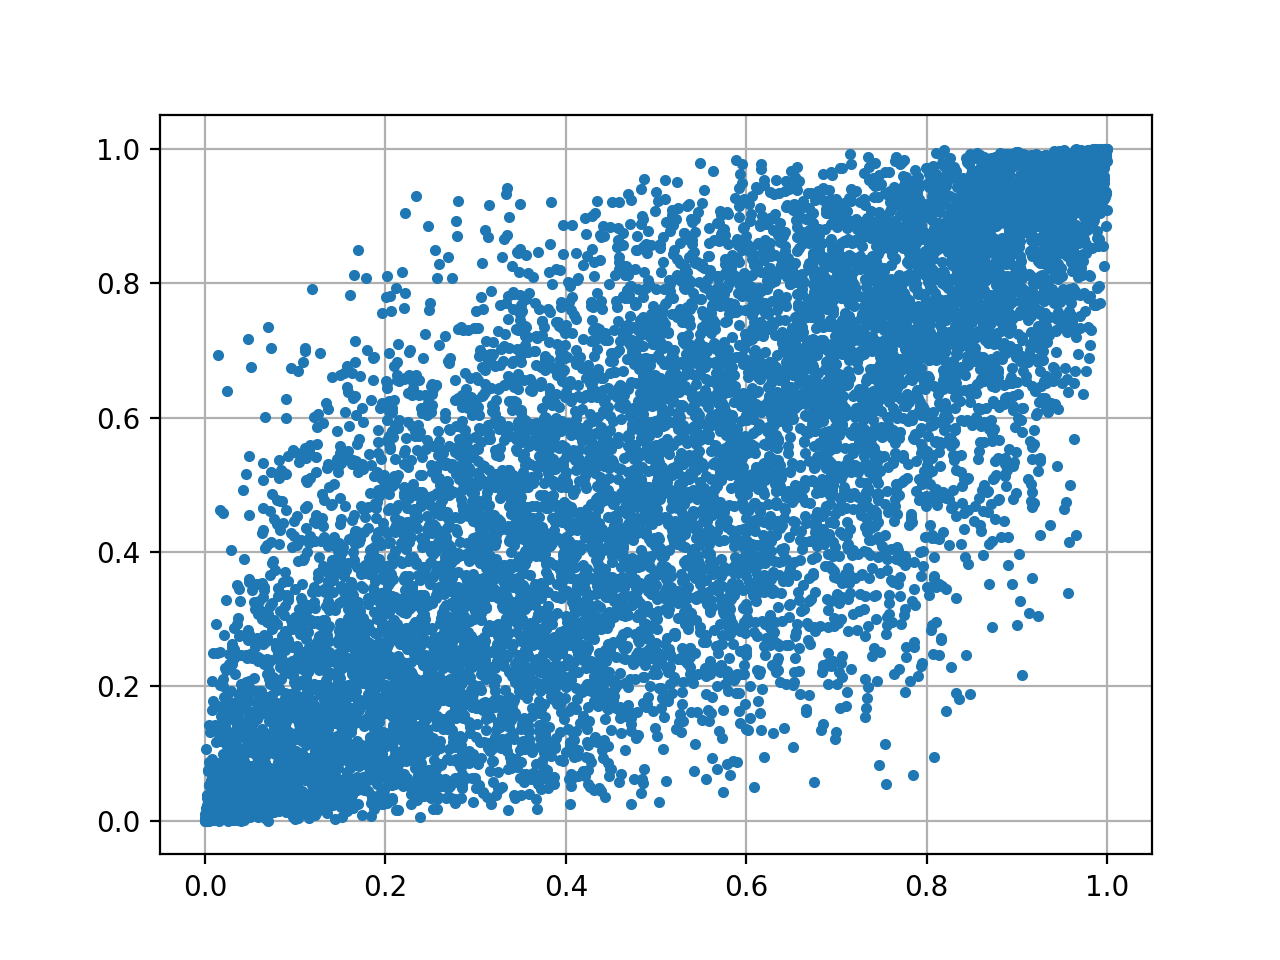

In [19]:
C = norm.cdf(Z)
u = C[:, 0]
v = C[:, 1]
plt.figure()
plt.plot(u, v, '.')
plt.grid(True)

The shape of the above plot says it all. We have transformed the bivariate Gaussian sample to the unit square such that the dependence structure of the original bivariate Gaussian sample is preserved. The correlation of the uniform sample can be seen directly in the above plot.

Are the marginals uniform? That's the most exciting aspect to check. The figure below suggestst that indeed, the marginals are uniform. 

<IPython.core.display.Javascript object>


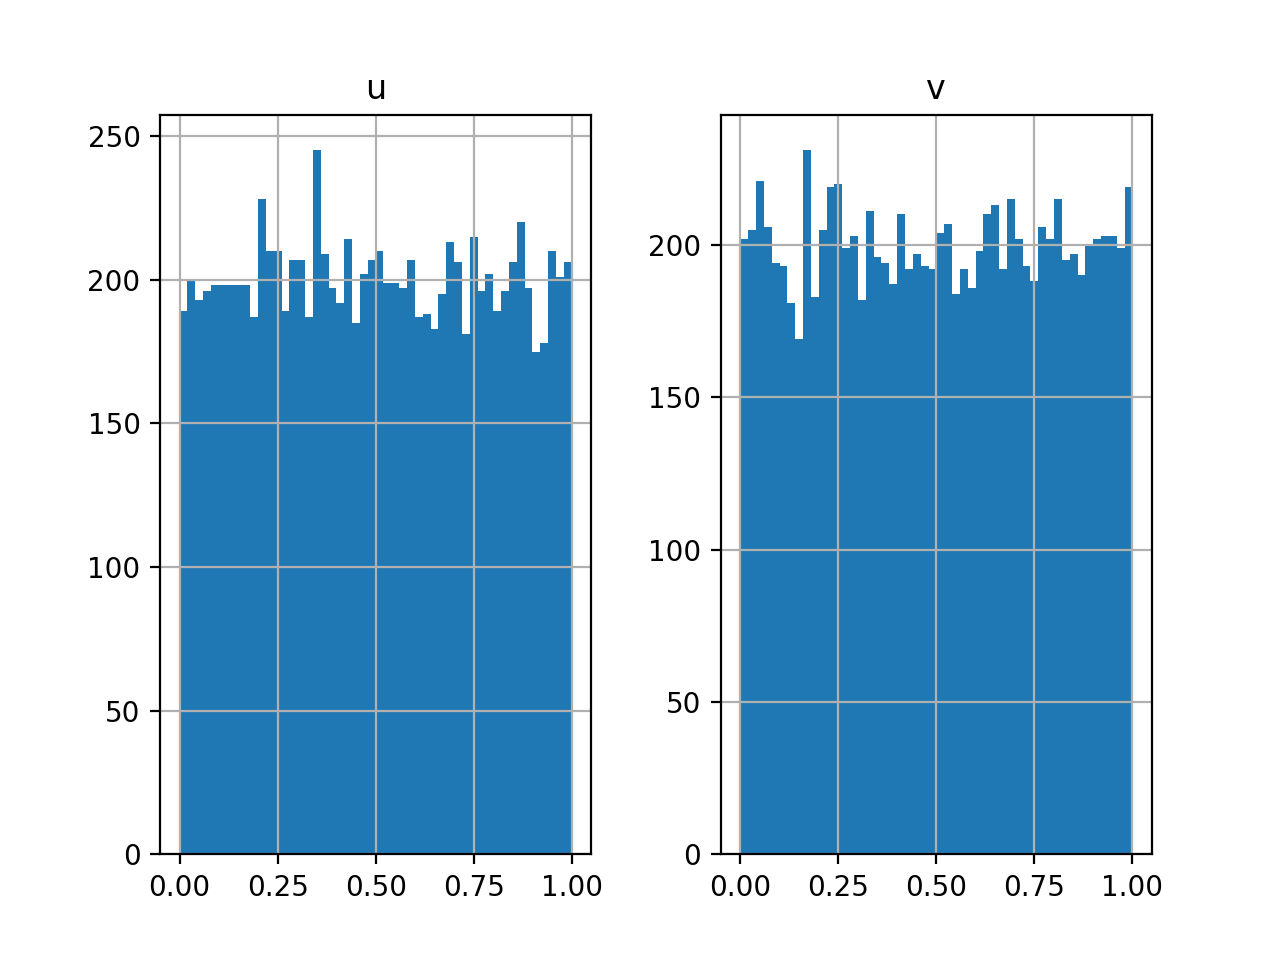

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fe6efd0>,
      dtype=object)

In [20]:
df_c = pd.DataFrame({'u': u, 'v': v})
df_c.hist(bins=50, grid=True)

In [21]:
df_c['u'].corr(df_c['v'])

0.787610750509914

Once we have the copula sample (the bivariate uniform sample generated by the Gaussian copula in this case), we can generate a sample with any new specified marginal distributions while mainting the same dependence structure. For example, we may want 
to generate a new sample from a joint distribution such that both the marginals are exponential.

To achive this, we simply transform the copula sample using inverse distribution functions of the new marginal distribution. 

<IPython.core.display.Javascript object>


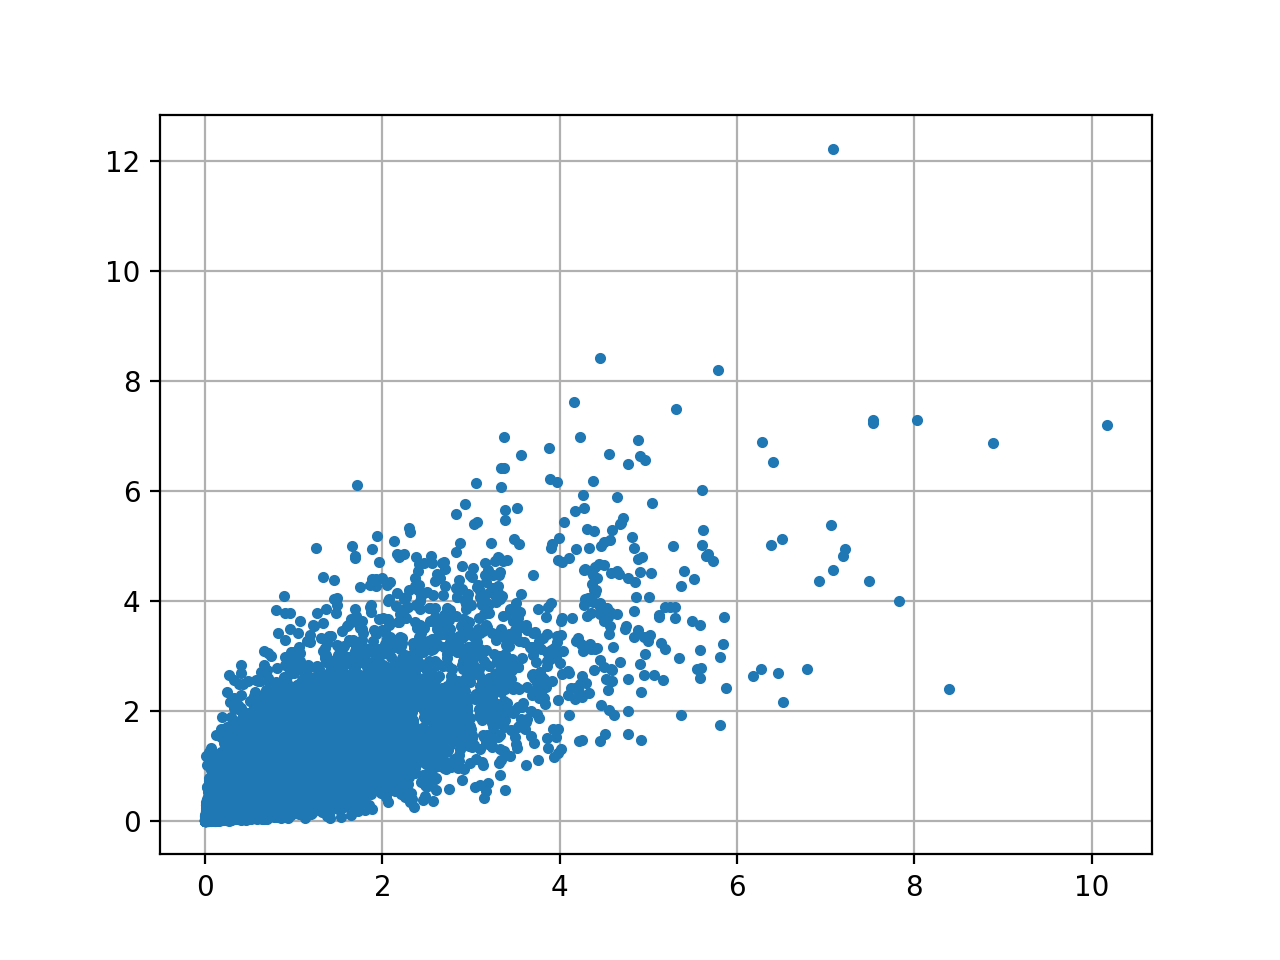

In [22]:
# ppf is the inverse cdf, i.e., the quantile transform
E = expon.ppf(C)
e_1 = E[:, 0]
e_2 = E[:, 1]
plt.figure()
plt.plot(e_1, e_2, '.')
plt.grid(True)

<IPython.core.display.Javascript object>


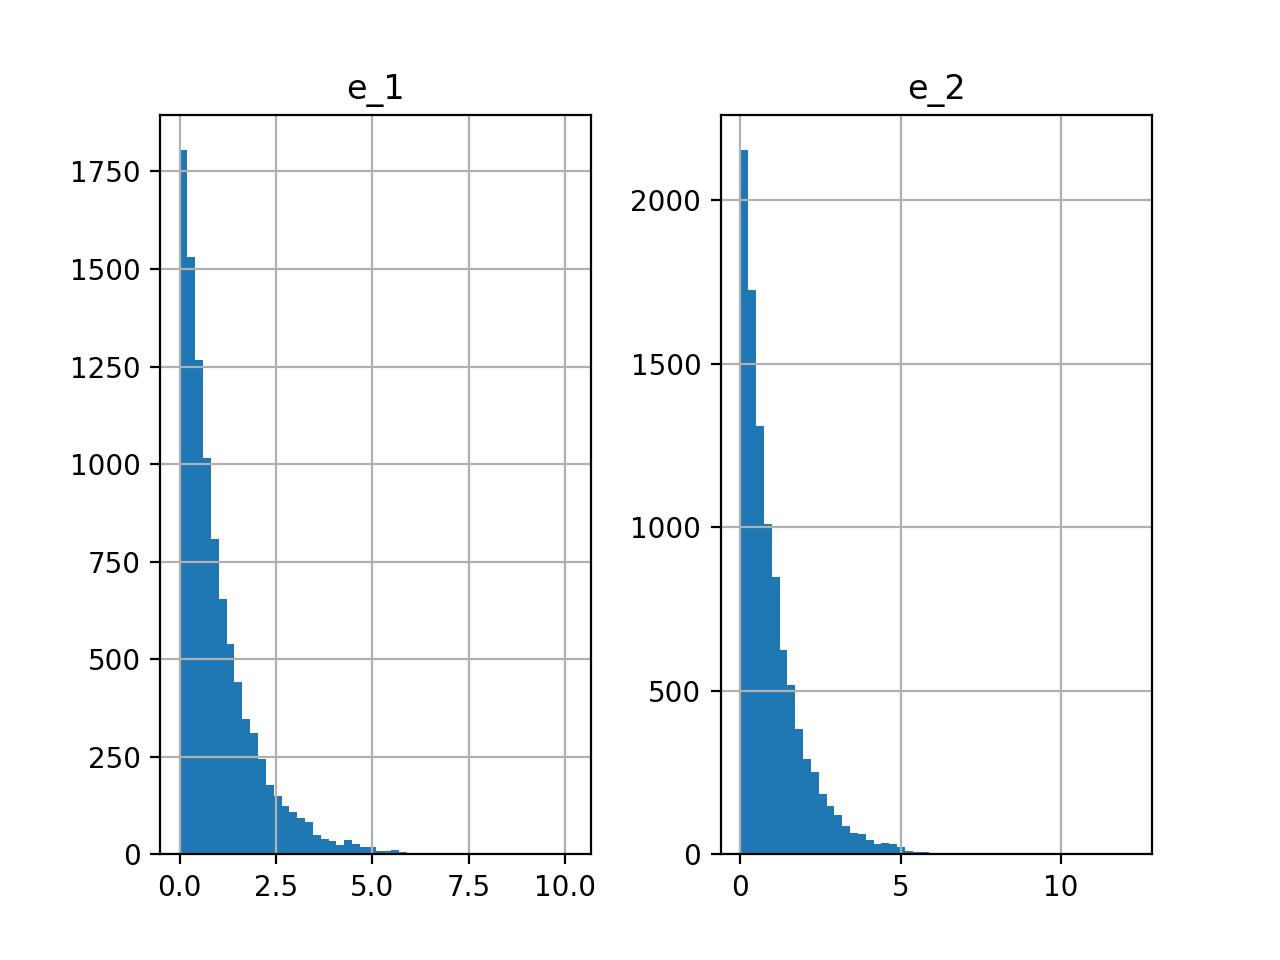

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123324438>,
      dtype=object)

In [23]:
df_e = pd.DataFrame({'e_1': e_1, 'e_2': e_2})
df_e.hist(bins=50, grid=True)

In [24]:
df_e['e_1'].corr(df_e['e_2'])

0.7742453672088413

Suppose now we want to generate a new sample from a joint distribution such that the marginals are lognormal and exponential. To achive this, we again transform the copula sample using the appropriate inverse distribution functions. 

<IPython.core.display.Javascript object>


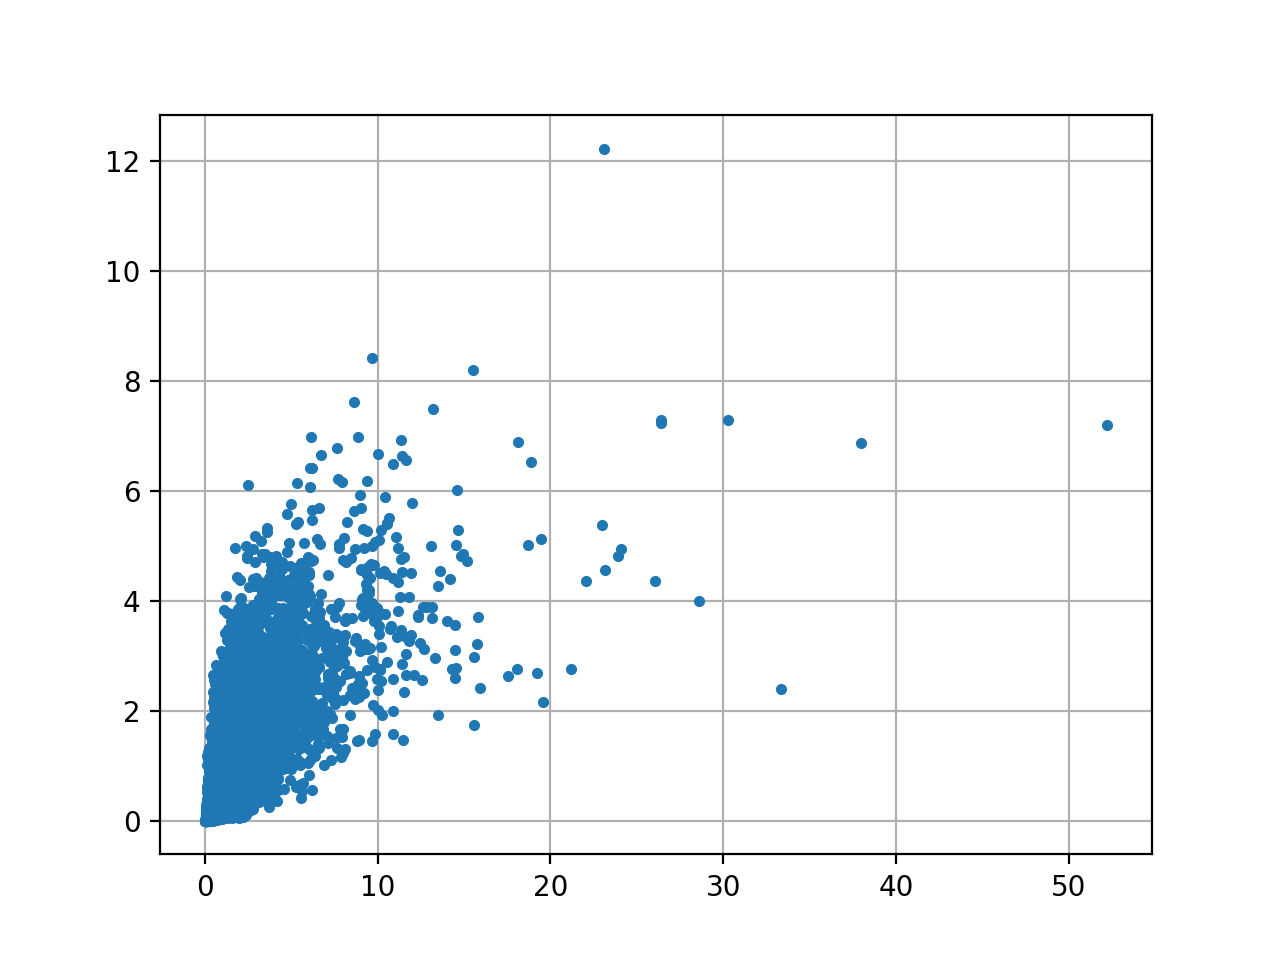

In [25]:
# ppf is the inverse cdf, i.e., the quantile transform
l = lognorm.ppf(C[:, 0], 1)
e = expon.ppf(C[:, 1])
plt.figure()
plt.plot(l, e, '.')
plt.grid(True)

<IPython.core.display.Javascript object>


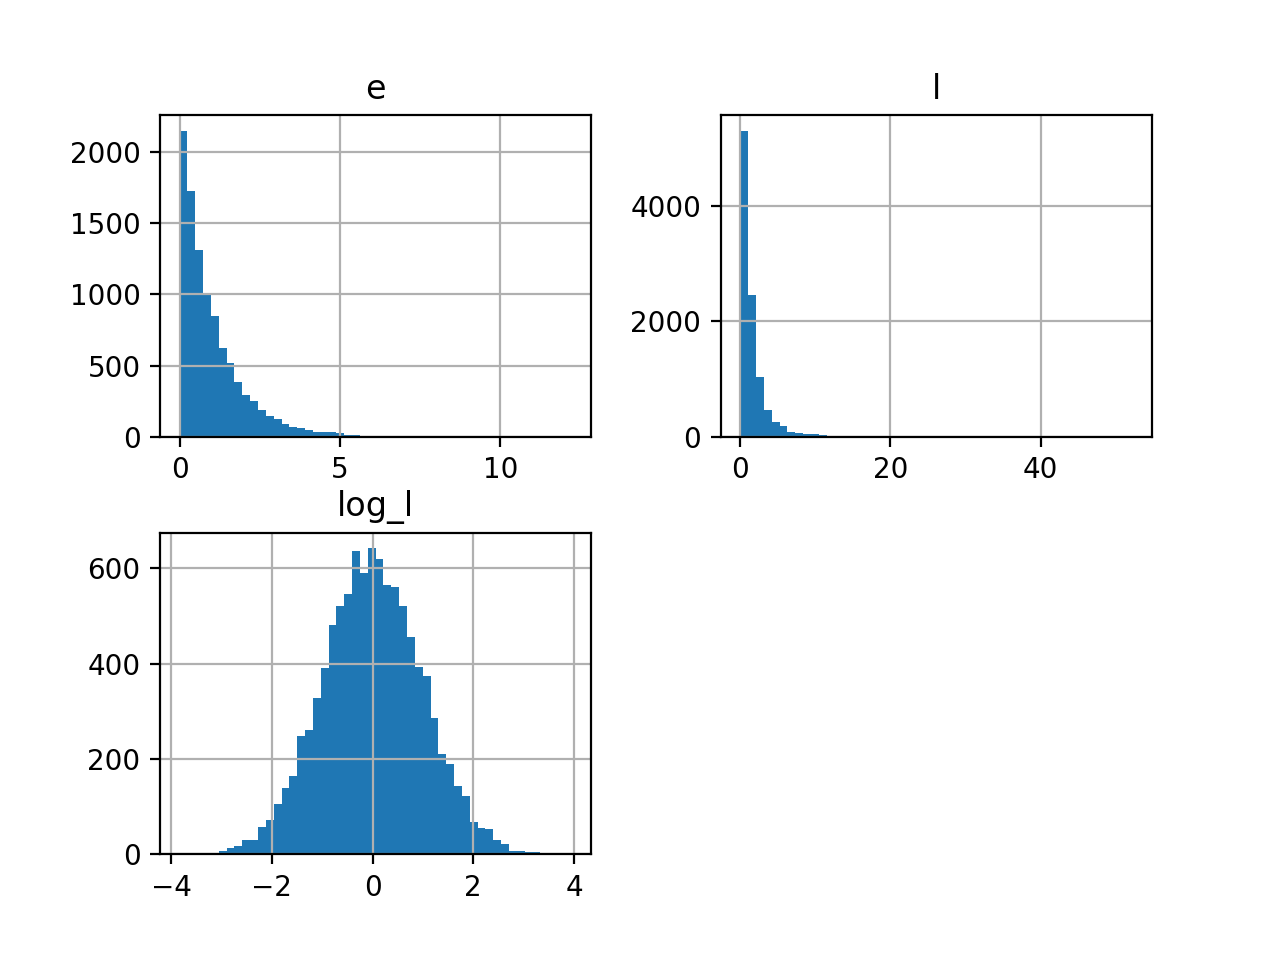

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123f16710>,
      dtype=object)

In [26]:
df_l = pd.DataFrame({'l': l, 'log_l': np.log(l), 'e': e})
df_l.hist(bins=50, grid=True)

## Where do we use this?

* I am long ten credit default swaps on different names. 
* The joint crash probability of these names is best modelled via a correlated multivariate Gaussian.
* The probability of getting a payout from each CDS is exponential.

In this case, 

* We will first create a sample from the multivariate Gaussian. 
* Then form the copula sample using the probability integral transfrom on each component. 
* On the copula sample, apply the inverse of the exponential distribution function. 
* The final sample will have exponential marginals by construction and the same dependence structure as that of the multivariate Gaussian. 

## Copula vs Correlation

Coupla captures the whoistic dependence structure between two random variables. Correlation on the other hand is 
just a measure of linear dependence. 


<IPython.core.display.Javascript object>


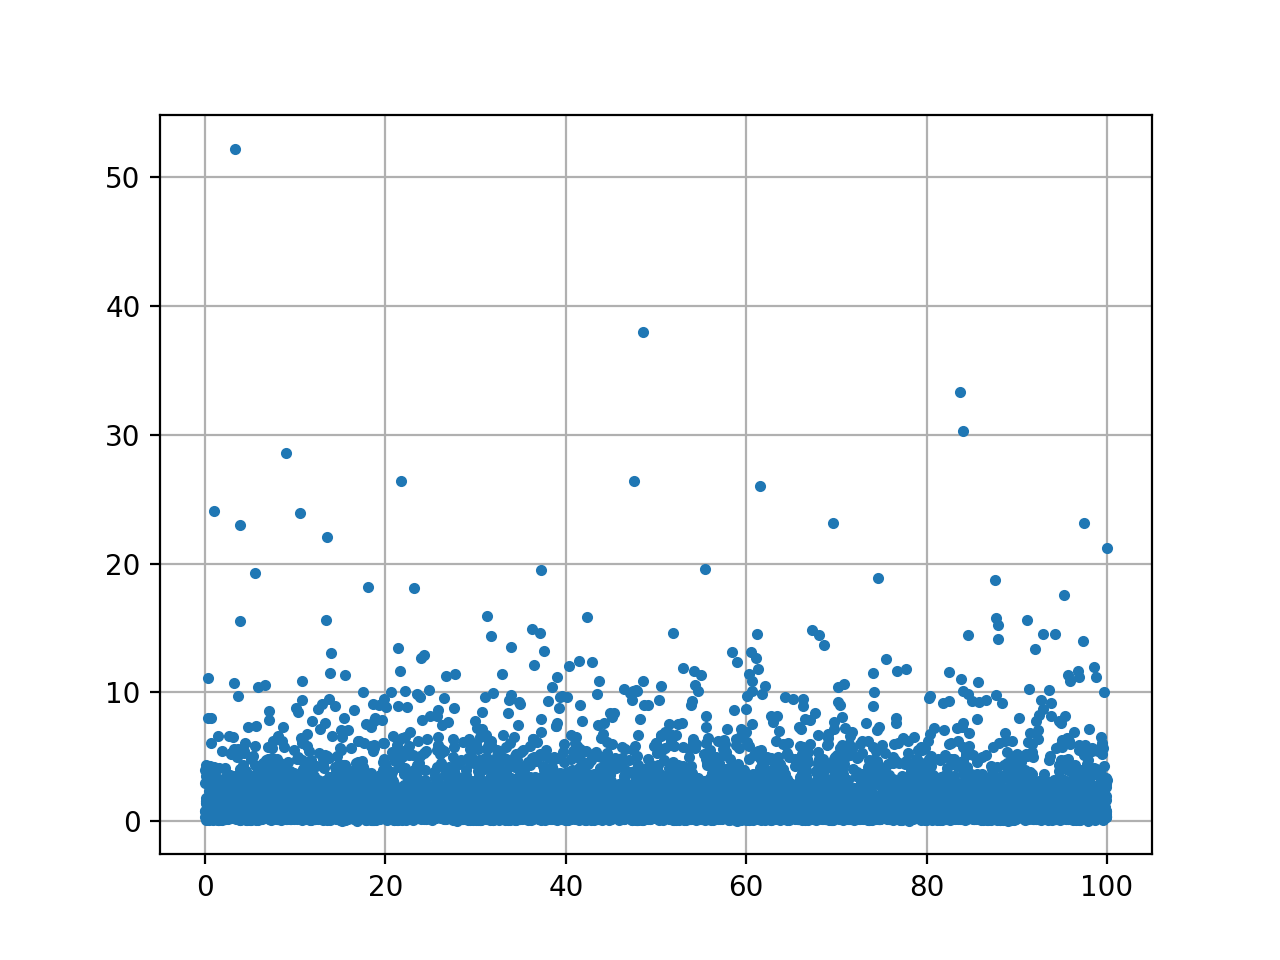

In [27]:
df_xy = pd.DataFrame( {'x': 100*np.random.rand(N), 'y': np.exp(X)});
plt.figure()
plt.plot(df_xy['x'], df_xy['y'], '.')
plt.grid()

In [29]:
df_xy['x'].corr(df_xy['y'])

-0.008057889008088265

In [ ]:
# Why is the above correlation so low?